In [1]:
%run setup.ipynb
%matplotlib inline
# don't use normal import:
# import hapclust
# instead do this:
%reload_ext autoreload
%autoreload 1
%aimport hapclust

#### setup data

In [2]:
# obtain data from unphased callset - only needed for variant annotations
callset = phase1_ar31.callset
pos_all = allel.SortedIndex(callset['2L/variants/POS'])
ann_all = callset['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
genotypes_phased.shape, pos_phased.shape

((8296600, 773, 2), (8296600,))

In [3]:
# define general region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]

# chop genotypes to region, remove colony parents (8 samples) and turn into haplotype array
gen_phased_region = genotypes_phased[loc_region][:, :-8].compute()

#mvn calls
callset_nu = np.load('../data/phasing_extra_phase1.mvncall.200.npz')
calldata_nu = callset_nu['calldata']
gen_nu = allel.GenotypeArray(calldata_nu['genotype'])
pos_nu = allel.SortedIndex(callset_nu['variants']['POS'])

haps_combined = np.concatenate([gen_phased_region, gen_nu], axis=0)
pos_combined = np.concatenate([pos_phased_region, pos_nu], axis=0)
idx_sorted =np.argsort(pos_combined)

haps_combined = allel.GenotypeArray(haps_combined[idx_sorted])
pos_combined = allel.SortedIndex(pos_combined[idx_sorted])

haps = haps_combined.to_haplotypes()

#chop into gene
region_vgsc = SeqFeature('2L', 2358158, 2431617)
loc = pos_combined.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haps[loc]
pos = pos_combined[loc]

h_vgsc

<HaplotypeArray shape=(1713, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [4]:
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))[ :-16]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])

In [5]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [6]:
len(tbl_variant_labels)

6348

In [7]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')

In [8]:
pos2label[2358254], len(pos)

('D33N', 1713)

In [9]:
variant_labels = np.array([pos2label.get(p, '') for p in pos], dtype=object)
# variant_labels_vgsc = variant_labels[loc]
# variant_labels_vgsc[:5]
variant_labels[:5]

array(['D33N', '', '', '', ''], dtype=object)

In [10]:
pos

0,1,2,3,4,...,1708,1709,1710,1711,1712
2358254,2358316,2358328,2358353,2358405,...,2431417,2431487,2431518,2431527,2431542


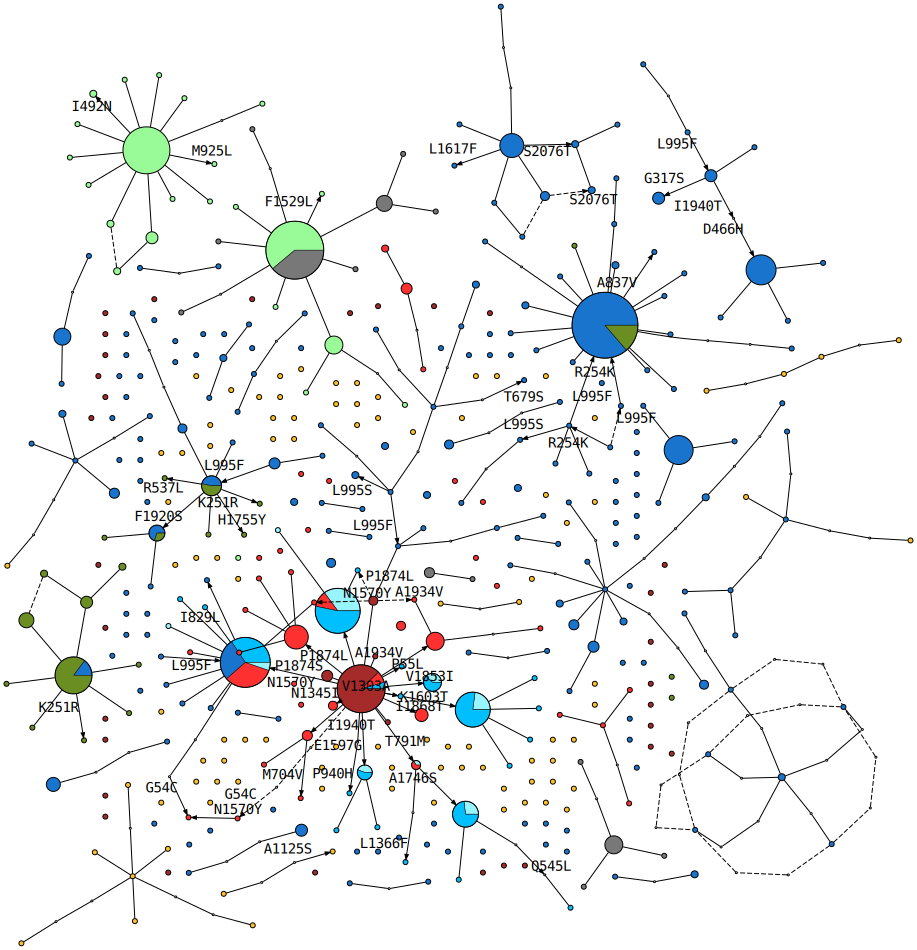

In [21]:
hapclust.graph_haplotype_network(h_vgsc, network_method='msn', 
                                 hap_colors=hap_colors, max_dist= 3, variant_labels=variant_labels)

In [12]:
pos_995S = 2422651
pos_995F = 2422652

In [13]:
loc_995S = h_vgsc[pos.locate_key(pos_995S)] == 1
loc_995F = h_vgsc[pos.locate_key(pos_995F)] == 1

In [14]:
np.count_nonzero(loc_995F), np.count_nonzero(loc_995S)

(775, 430)

In [15]:
#kdr haps
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)

In [16]:
#colours
hap_colors_995F = hap_colors.compress(loc_995F)
hap_colors_995S = hap_colors.compress(loc_995S)

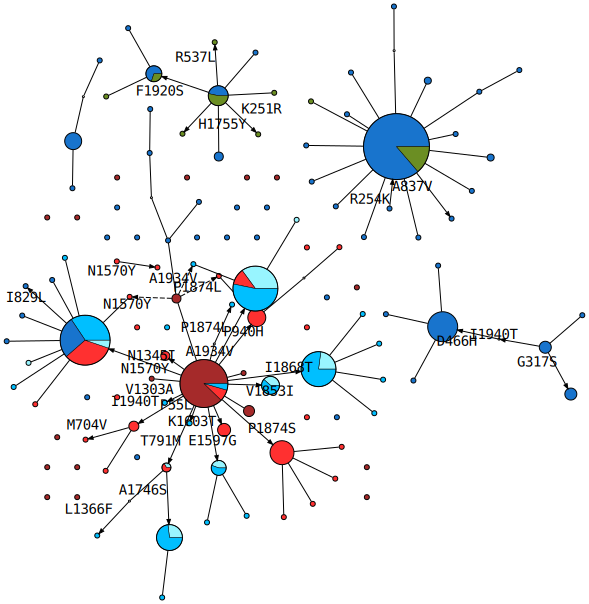

In [41]:
graph, hapcounts = hapclust.graph_haplotype_network(h_vgsc_995F, network_method='msn', max_dist=2, hap_colors=hap_colors_995F, variant_labels=variant_labels)

graph.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_clusters_msn_maxdist2'
graph.render(fn)

graph

In [42]:
len(hapcounts)

123

In [55]:
hapcounts[46]

1

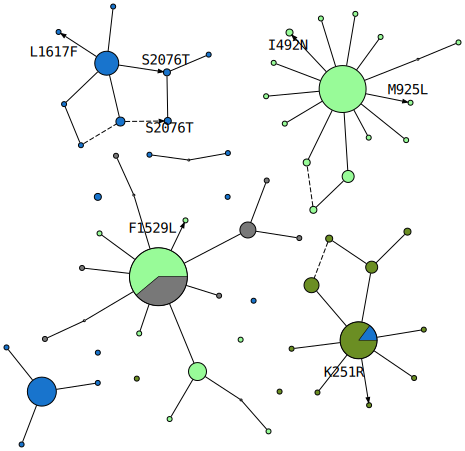

In [37]:
graph, hapcounts = hapclust.graph_haplotype_network(h_vgsc_995S, network_method='msn', max_dist=2, hap_colors=hap_colors_995S, variant_labels=variant_labels)

graph.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_clusters_msn_maxdist2'
graph.render(fn)

graph

In [40]:
hapcounts[37]

54

In [19]:
# TO DO
#kick out these as svg with/without labels then chuck into inkscape and colour non-syn edges